# Предсказание популярности песен

В файле songs_data.csv собраны данные по характеристикам песен и их популярности.

По имеющемуся набору данных, необходимо построить модель, которая будет прогнозировать значение целевой переменной 'song_popularity'.

In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 5]
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFE
!pip install shap
import shap
!pip install interpret
import interpret.glassbox

from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2

from sklearn.pipeline import make_pipeline

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dropout
from keras.layers import Dense
from keras.models import Sequential

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 15.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.0/758.0 kB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 79.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 91.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 22.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## EDA

In [2]:
df = pd.read_csv('song_data.csv')
original_df = df.copy(deep=True)
df.head()

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_name         18835 non-null  object 
 1   song_popularity   18835 non-null  int64  
 2   song_duration_ms  18835 non-null  int64  
 3   acousticness      18835 non-null  float64
 4   danceability      18835 non-null  float64
 5   energy            18835 non-null  float64
 6   instrumentalness  18835 non-null  float64
 7   key               18835 non-null  int64  
 8   liveness          18835 non-null  float64
 9   loudness          18835 non-null  float64
 10  audio_mode        18835 non-null  int64  
 11  speechiness       18835 non-null  float64
 12  tempo             18835 non-null  float64
 13  time_signature    18835 non-null  int64  
 14  audio_valence     18835 non-null  float64
dtypes: float64(9), int64(5), object(1)
memory usage: 2.2+ MB


In [4]:
df.describe()

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
count,18835.000000,1.883500e+04,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000
mean,52.991877,2.182116e+05,0.258539,0.633348,0.644995,0.078008,5.289196,0.179650,-7.447435,0.628139,0.102099,121.073154,3.959119,0.527967
std,21.905654,5.988754e+04,0.288719,0.156723,0.214101,0.221591,3.614595,0.143984,3.827831,0.483314,0.104378,28.714456,0.298533,0.244632
min,0.000000,1.200000e+04,0.000001,0.000000,0.001070,0.000000,0.000000,0.010900,-38.768000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,1.843395e+05,0.024100,0.533000,0.510000,0.000000,2.000000,0.092900,-9.044000,0.000000,0.037800,98.368000,4.000000,0.335000
50%,56.000000,2.113060e+05,0.132000,0.645000,0.674000,0.000011,5.000000,0.122000,-6.555000,1.000000,0.055500,120.013000,4.000000,0.527000
75%,69.000000,2.428440e+05,0.424000,0.748000,0.815000,0.002570,8.000000,0.221000,-4.908000,1.000000,0.119000,139.931000,4.000000,0.725000
max,100.000000,1.799346e+06,0.996000,0.987000,0.999000,0.997000,11.000000,0.986000,1.585000,1.000000,0.941000,242.318000,5.000000,0.984000


Вывод:
- предварительно аномалии не обнаружены

In [5]:
# sns.pairplot(df)    НАДО РАЗКОММЕНТИРОВАТЬ ПОСЛЕ ОКОНЧАНИЯ РАБОТЫ!!!

In [6]:
df = df.drop(['song_name'], axis=1)   # удаление признака с названием песни

In [7]:
df.nunique().sort_values()

audio_mode              2
time_signature          5
key                    12
song_popularity       101
danceability          849
energy               1132
speechiness          1224
audio_valence        1246
liveness             1425
acousticness         3209
instrumentalness     3925
loudness             8416
song_duration_ms    11771
tempo               12112
dtype: int64

Выводы:
- датасет содержит 3 категориальных признака
- кроме этого в датасете 10 числовых признаков и 1 целевой признак

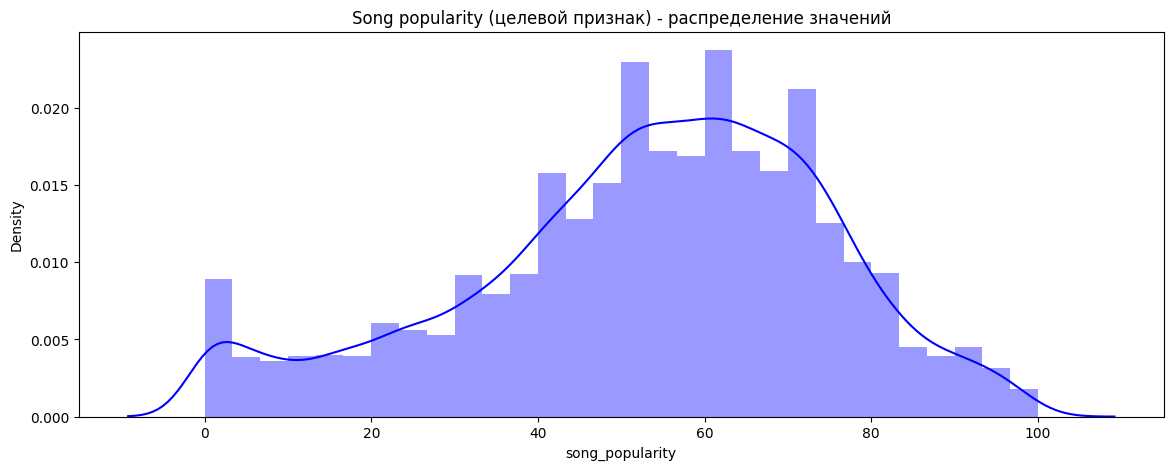

In [8]:
# Song popularity - популярность песни (целевой признак)
sns.distplot(df['song_popularity'], color='b', bins=30)
plt.title('Song popularity (целевой признак) - распределение значений')
plt.show()

Вывод:
- визуально распределение целевого признака близко к нормальному (с выбросом в левой части распределения)

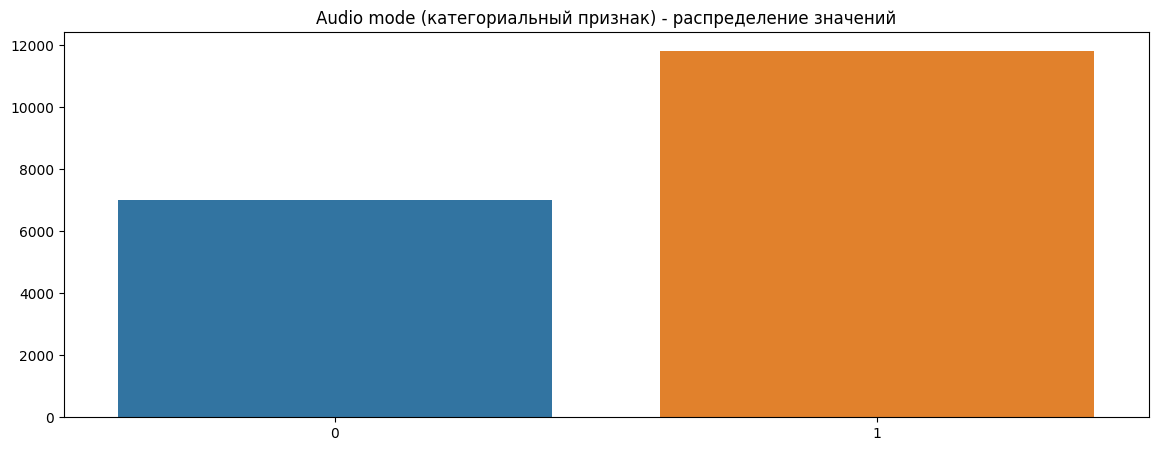

In [9]:
# Audio mode - мажорность/минорность композиции (категориальный признак)
df_plot = df.groupby('audio_mode')['audio_mode'].count()
vals = list(df_plot.values)
idx = list(df_plot.index)
sns.barplot(data=df, x=idx, y=vals)
plt.title('Audio mode (категориальный признак) - распределение значений')
plt.show()

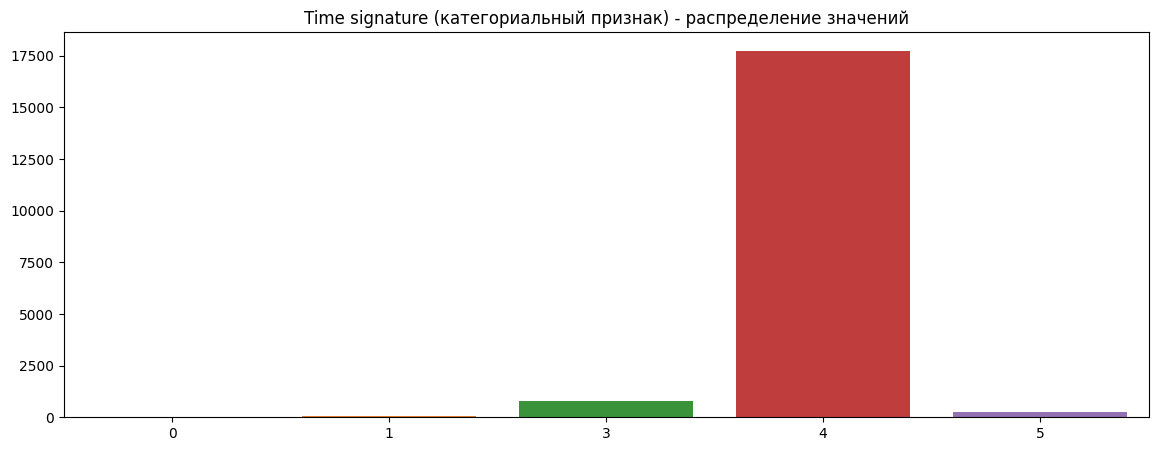

In [10]:
# Time signature - музыкальный размер (категориальный признак)
df_plot = df.groupby('time_signature')['time_signature'].count()
vals = list(df_plot.values)
idx = list(df_plot.index)
sns.barplot(data=df, x=idx, y=vals)
plt.title('Time signature (категориальный признак) - распределение значений')
plt.show()

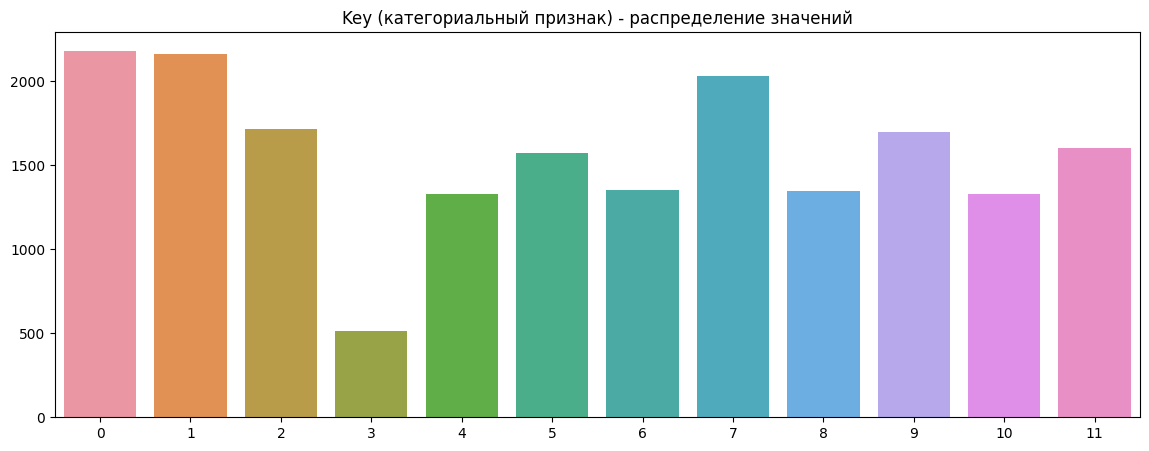

In [11]:
# Key - тональность (категориальный признак)
df_plot = df.groupby('key')['key'].count()
vals = list(df_plot.values)
idx = list(df_plot.index)
sns.barplot(data=df, x=idx, y=vals)
plt.title('Key (категориальный признак) - распределение значений')
plt.show()

Выводы по категориальным признакам:
- бОльшая часть песен имеет значение audio_mode "1" (в связи с отсутствием расшифровки данных будем далее предполагать, что это стереоформат)
- подавляющая часть песен имеет размер 4/4 (полный такт)
- наиболее популярные тональности песен - 0, 1 и 7, наименее популярная - 3

In [12]:
# Числовые признаки:
# - danceability - "танцевабельность"
# - energy - "энергичность"
# - speechiness - насыщенность текстом
# - audio_valence - "музыкальная позитивность"
# - liveness - живость
# - acousticness - акустичность
# - instrumentalness - инструментальность
# - loudness - громкость
# - song_duration_ms - длительность песни (в милисекундах)
# - tempo - темп (bpm)

Распределение числовых признаков


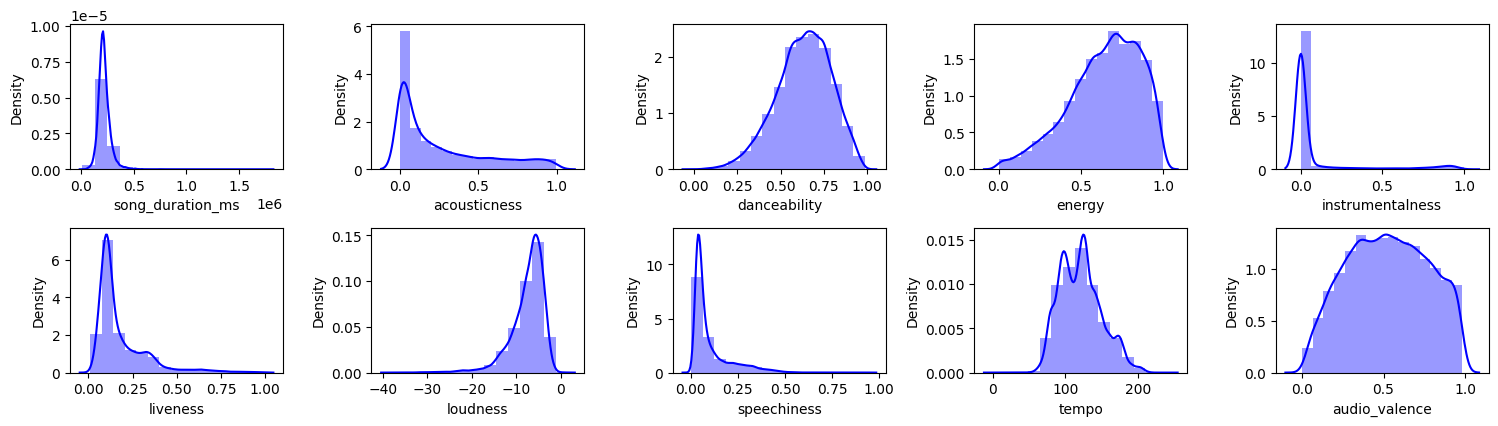

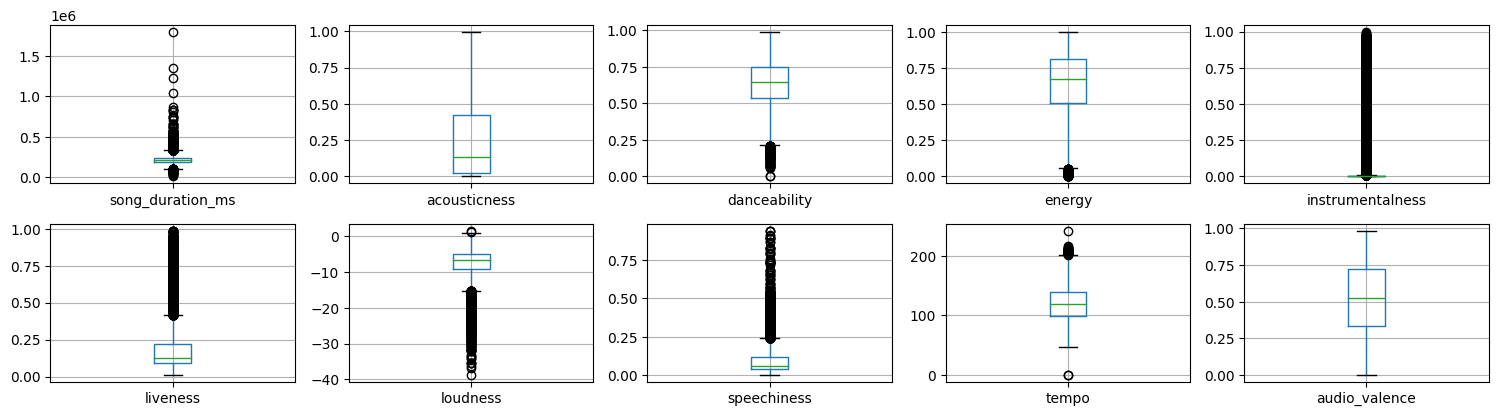

In [13]:
print('Распределение числовых признаков')
clr=['b','b','b','b','b','b']
features = df.drop(['audio_mode', 'time_signature', 'key', 'song_popularity'], axis=1).columns
qty = len(features)
n = int(qty / 2)

plt.figure(figsize=[15, 4*math.ceil(qty/n)])
for i in range(qty):
    plt.subplot(math.ceil(qty/3), n, i+1)
    sns.distplot(df[features[i]], bins=15, color='b')
plt.tight_layout()
plt.show()

plt.figure(figsize=[15, 4*math.ceil(qty/n)])
for i in range(qty):
    plt.subplot(math.ceil(qty/3), n, i+1)
    df.boxplot(features[i])
plt.tight_layout()
plt.show()

Вывод:
- требуется обработка выбросов по отдельным признакам

## Предобработка данных

### Обработка дубликатов

In [14]:
original_len = len(df)
print(f'Исходный объем датасета: {original_len} записей')
unduplicated_len = len(df.drop_duplicates())
print(f'Выявлено строк-дубликатов: {original_len - unduplicated_len} записей')

Исходный объем датасета: 18835 записей
Выявлено строк-дубликатов: 3911 записей


In [15]:
df.drop_duplicates(inplace=True)
print(f'Длина датасета после удаления строк-дубликатов:  {len(df)} записей')
print(f'Доля удаленных записей:  {round((original_len - unduplicated_len) * 100 / original_len, 1)} %')

Длина датасета после удаления строк-дубликатов:  14924 записей
Доля удаленных записей:  20.8 %


Вывод:
- исходный датасет содержал значительное количество дублирующих записей
- по результатам удаления дубликатов объем датасета значительно снизился

### Обработка пропусков

In [16]:
df.isna().sum()

song_popularity     0
song_duration_ms    0
acousticness        0
danceability        0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
audio_mode          0
speechiness         0
tempo               0
time_signature      0
audio_valence       0
dtype: int64

In [17]:
# def get_value(X, column, mode='mean', value=0, columns_for_reg=None):
#     if mode == 'value':
#         X.loc[X[X[column].isna()].index ,column] = value # заполнение значением
#     elif mode == 'max':
#         X.loc[X[X[column].isna()].index ,column] = X[column].max() # заполнение max
#     elif mode == 'min':
#         X.loc[X[X[column].isna()].index ,column] = X[column].min()  # заполнение min
#     elif mode == 'median':
#         X.loc[X[X[column].isna()].index ,column] = X[column].median()    # заполнение медианой
#     elif mode == 'mode':
#         X.loc[X[X[column].isna()].index, column] = X[column].mode()[0]   # заполнение модой
#     elif mode == 'indicator': # метод индикатора (принимает значение 1 при наличие пропуска и 0 в остальных случаях)
#         X['ind_'+str(column)] = 0
#         X.loc[X[X[column].isna()].index, 'ind_'+str(column)] = 1
#         X.loc[X[X[column].isna()].index, column] = 0
#     elif mode == 'linreg':   # линейная регрессия
#         if columns_for_reg is None:
#             cols = list(X.select_dtypes([np.number]).columns)
#             cols.remove(column)
#         else:
#             cols = columns_for_reg
#         X_tmp = X.dropna()
#         m = LinearRegression().fit(X_tmp[cols], X_tmp[column])
#         X.loc[X[X[column].isna()].index, column] = m.predict(X[X[column].isna()][cols])
#     else:
#         X.loc[X[X[column].isna()].index, column] = X[column].mean()  # по умолчанию среднее значение
#     return X.head(3)

In [18]:
# df = df(df['...'].isna())
# get_value(df, '...', mode='...', columns_for_reg=['...', '...'])

Вывод:
- пропуски в датасете отсутствуют

### Dummy-кодирование и LabelEncoding категориальных переменных

In [19]:
df.head()

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574


In [20]:
categoricals_dummies = ['time_signature', 'key']

for feat in categoricals_dummies:
    df = df.join(pd.get_dummies(df[feat], drop_first=True, prefix=feat)).drop(feat, axis=1)

In [21]:
categoricals_le = ['audio_mode']

for feat in categoricals_le:
    df[feat]= LabelEncoder().fit_transform(df[feat])

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14924 entries, 0 to 18834
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_popularity   14924 non-null  int64  
 1   song_duration_ms  14924 non-null  int64  
 2   acousticness      14924 non-null  float64
 3   danceability      14924 non-null  float64
 4   energy            14924 non-null  float64
 5   instrumentalness  14924 non-null  float64
 6   liveness          14924 non-null  float64
 7   loudness          14924 non-null  float64
 8   audio_mode        14924 non-null  int64  
 9   speechiness       14924 non-null  float64
 10  tempo             14924 non-null  float64
 11  audio_valence     14924 non-null  float64
 12  time_signature_1  14924 non-null  uint8  
 13  time_signature_3  14924 non-null  uint8  
 14  time_signature_4  14924 non-null  uint8  
 15  time_signature_5  14924 non-null  uint8  
 16  key_1             14924 non-null  uint8 

### Обработка выбросов

Исходя из боксплотов и гистограмм, построенных ранее в разделе EDA:
- по признакам "song_duration_ms", "tempo", "loudness" проведем "ручную" (экспертную) обработку выбросов
- по прочим числовым признакам проведем автоматизированную обработку выбросов

In [23]:
# признак 'song_duration_ms': продолжительность песни (в милисекундах)
# минимальное значение признака зададим - 60 секунд (зачастую такой минимум устанавливается на стриминговых сервисах)
# максимальное значение признака зададим - 12 минут (имеются треки такой длины, например, в стиле prog rock)

min_dur = 60*1000
max_dur = 12*60*1000
df = df[(df['song_duration_ms'] >= min_dur) & (df['song_duration_ms'] <= max_dur)]
mv_len_1 = len(df)

print(f'Исходный объем датасета: {original_len} записей')
print(f'Длина датасета после удаления строк-дубликатов:  {unduplicated_len} записей')
print(f'Удалено выбросов: {unduplicated_len - mv_len_1} записей')
print(f'Длина датасета после удаления строк-дубликатов и выбросов по длине песен:  {mv_len_1} записей')
print(f'Доля удаленных записей (от исходного объема датасета):  {round((unduplicated_len - mv_len_1) * 100 / original_len, 1)} %')

Исходный объем датасета: 18835 записей
Длина датасета после удаления строк-дубликатов:  14924 записей
Удалено выбросов: 27 записей
Длина датасета после удаления строк-дубликатов и выбросов по длине песен:  14897 записей
Доля удаленных записей (от исходного объема датасета):  0.1 %


In [24]:
# признак 'tempo': темп песни (удары в минуту, bpm)
# минимальное значение признака зададим - 40 bpm (это чрезвычайно низкий темп, соответствующий понятию "Largo")
# максимальное значение признака зададим - 200 bpm (это чрезвычайно высокий темп, соответствующий понятию "Prestissimo")

min_tempo = 40
max_tempo = 200
df = df[(df['tempo'] >= min_tempo) & (df['tempo'] <= max_tempo)]
mv_len_2 = len(df)

print(f'Исходный объем датасета: {original_len} записей')
print(f'Длина датасета после удаления строк-дубликатов и выбросов по длине песен:  {mv_len_1} записей')
print(f'Удалено выбросов: {mv_len_1 - mv_len_2} записей')
print(f'Длина датасета после удаления строк-дубликатов и выбросов по длине песен:  {mv_len_2} записей')
print(f'Доля удаленных записей (от исходного объема датасета):  {round((mv_len_1 - mv_len_2) * 100 / original_len, 1)} %')

Исходный объем датасета: 18835 записей
Длина датасета после удаления строк-дубликатов и выбросов по длине песен:  14897 записей
Удалено выбросов: 96 записей
Длина датасета после удаления строк-дубликатов и выбросов по длине песен:  14801 записей
Доля удаленных записей (от исходного объема датасета):  0.5 %


In [25]:
# признак 'loudness': громкость песни (в децибелах по относительной шкале, где 0 - порог перегрузки)
# минимальное значение признака зададим - -25 дб (уровнь звука, соответствующий речи)
# максимальное значение признака зададим - 0 дб (отсутствие перегрузки по уровню звука)

min_loud = -25
max_loud = 0
df = df[(df['loudness'] >= min_loud) & (df['loudness'] <= max_loud)]
mv_len_3 = len(df)

print(f'Исходный объем датасета: {original_len} записей')
print(f'Длина датасета после удаления строк-дубликатов и выбросов по длине и темпу песен:  {mv_len_2} записей')
print(f'Удалено выбросов: {mv_len_2 - mv_len_3} записей')
print(f'Длина датасета после удаления строк-дубликатов и выбросов по громкости песен:  {mv_len_3} записей')
print(f'Доля удаленных записей (от исходного объема датасета):  {round((mv_len_2 - mv_len_3) * 100 / original_len, 1)} %')

Исходный объем датасета: 18835 записей
Длина датасета после удаления строк-дубликатов и выбросов по длине и темпу песен:  14801 записей
Удалено выбросов: 97 записей
Длина датасета после удаления строк-дубликатов и выбросов по громкости песен:  14704 записей
Доля удаленных записей (от исходного объема датасета):  0.5 %


In [26]:
manual_outliers_list = ['song_duration_ms', 'tempo', 'loudness']
auto_outliers_list = list(df.columns)
for el in manual_outliers_list:
    auto_outliers_list.remove(el)
del auto_outliers_list[0]     # целевой признак
del auto_outliers_list[5]     # audio_mode
del auto_outliers_list[7:]    # категориальные признаки
auto_outliers_list

['acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'liveness',
 'speechiness',
 'audio_valence']

In [27]:
df2 = df.copy()

In [28]:
for feature in auto_outliers_list:
    cur_df_len = len(df2)
    Q1 = df2[feature].quantile(0.25)
    Q3 = df2[feature].quantile(0.75)
    IQR = Q3 - Q1
    df2 = df2[df2[feature] <= Q3 + 1.5*IQR]
    df2 = df2[df2[feature] >= Q1 - 1.5*IQR]
    handled_len = len(df2)
    df2 = df2.reset_index(drop=True)
    print(f'По признаку "{feature}" удалено {cur_df_len - handled_len} выбросов')
    print(f'Это составляет {round((cur_df_len - handled_len) * 100 / original_len, 1)} % объема исходного датасета')
    print()

По признаку "acousticness" удалено 0 выбросов
Это составляет 0.0 % объема исходного датасета

По признаку "danceability" удалено 91 выбросов
Это составляет 0.5 % объема исходного датасета

По признаку "energy" удалено 22 выбросов
Это составляет 0.1 % объема исходного датасета

По признаку "instrumentalness" удалено 3125 выбросов
Это составляет 16.6 % объема исходного датасета

По признаку "liveness" удалено 685 выбросов
Это составляет 3.6 % объема исходного датасета

По признаку "speechiness" удалено 1215 выбросов
Это составляет 6.5 % объема исходного датасета

По признаку "audio_valence" удалено 0 выбросов
Это составляет 0.0 % объема исходного датасета



Вывод:
- по признакам "instrumentalness", "speechiness" и "liveliness" отсеян чрезмерно большой объем данных
- по указанным признакам требуется отдельная, более мягкая, обработка выбросов

In [29]:
# повторная обработка по всем числовым признакам, кроме "instrumentalness" и "speechiness"

auto_outliers_list = ['acousticness', 'danceability', 'energy', 'audio_valence']

for feature in auto_outliers_list:
    cur_df_len = len(df)
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    df = df[df[feature] <= Q3 + 1.5*IQR]
    df = df[df[feature] >= Q1 - 1.5*IQR]
    handled_len = len(df)
    df = df.reset_index(drop=True)
    print(f'По признаку "{feature}" удалено {cur_df_len - handled_len} выбросов')
    print(f'Это составляет {round((cur_df_len - handled_len) * 100 / original_len, 1)} % объема исходного датасета')
    print()

По признаку "acousticness" удалено 0 выбросов
Это составляет 0.0 % объема исходного датасета

По признаку "danceability" удалено 91 выбросов
Это составляет 0.5 % объема исходного датасета

По признаку "energy" удалено 22 выбросов
Это составляет 0.1 % объема исходного датасета

По признаку "audio_valence" удалено 0 выбросов
Это составляет 0.0 % объема исходного датасета



In [30]:
auto_outliers_list_soft = ['liveness', 'instrumentalness', 'speechiness']

# исходя из гистограмм и боксплотов, построенных на этапе EDA, большинство значений смещено в район нулевых значений
# фильтрацию будем проводить только по верхней стороне

for feature in auto_outliers_list_soft:
    Qmax = df[feature].quantile(0.97)
    df = df[df[feature] <= Qmax]
    handled_len = len(df)
    df = df.reset_index(drop=True)
    print(f'По признаку "{feature}" удалено {cur_df_len - handled_len} выбросов')
    print(f'Это составляет {round((cur_df_len - handled_len) * 100 / original_len, 1)} % объема исходного датасета')
    print()

По признаку "liveness" удалено 438 выбросов
Это составляет 2.3 % объема исходного датасета

По признаку "instrumentalness" удалено 860 выбросов
Это составляет 4.6 % объема исходного датасета

По признаку "speechiness" удалено 1269 выбросов
Это составляет 6.7 % объема исходного датасета



In [31]:
print(f'Объем исходного датасета:      {original_len} записей')
print(f'Объем обработанного датасета:  {len(df)} записей')
print(f'Доля сохраненных записей:      {round(len(df) * 100 / original_len, 1)} %')

Объем исходного датасета:      18835 записей
Объем обработанного датасета:  13322 записей
Доля сохраненных записей:      70.7 %


### Генерация полезных признаков

Дополнительная генерация признаков, с учетом специфики и структуры датасета, не целесообразна.

## Разбиение и масштабирование данных

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13322 entries, 0 to 13321
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_popularity   13322 non-null  int64  
 1   song_duration_ms  13322 non-null  int64  
 2   acousticness      13322 non-null  float64
 3   danceability      13322 non-null  float64
 4   energy            13322 non-null  float64
 5   instrumentalness  13322 non-null  float64
 6   liveness          13322 non-null  float64
 7   loudness          13322 non-null  float64
 8   audio_mode        13322 non-null  int64  
 9   speechiness       13322 non-null  float64
 10  tempo             13322 non-null  float64
 11  audio_valence     13322 non-null  float64
 12  time_signature_1  13322 non-null  uint8  
 13  time_signature_3  13322 non-null  uint8  
 14  time_signature_4  13322 non-null  uint8  
 15  time_signature_5  13322 non-null  uint8  
 16  key_1             13322 non-null  uint8 

In [33]:
y = df['song_popularity']     # целевой признак
X = df[df.columns[1:]]        # датасет фичей

In [34]:
X.shape

(13322, 26)

In [35]:
y.shape

(13322,)

In [36]:
# разбиение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

In [37]:
# масштабирование данных
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Отбор признаков для построения моделей

### Матрица корреляций

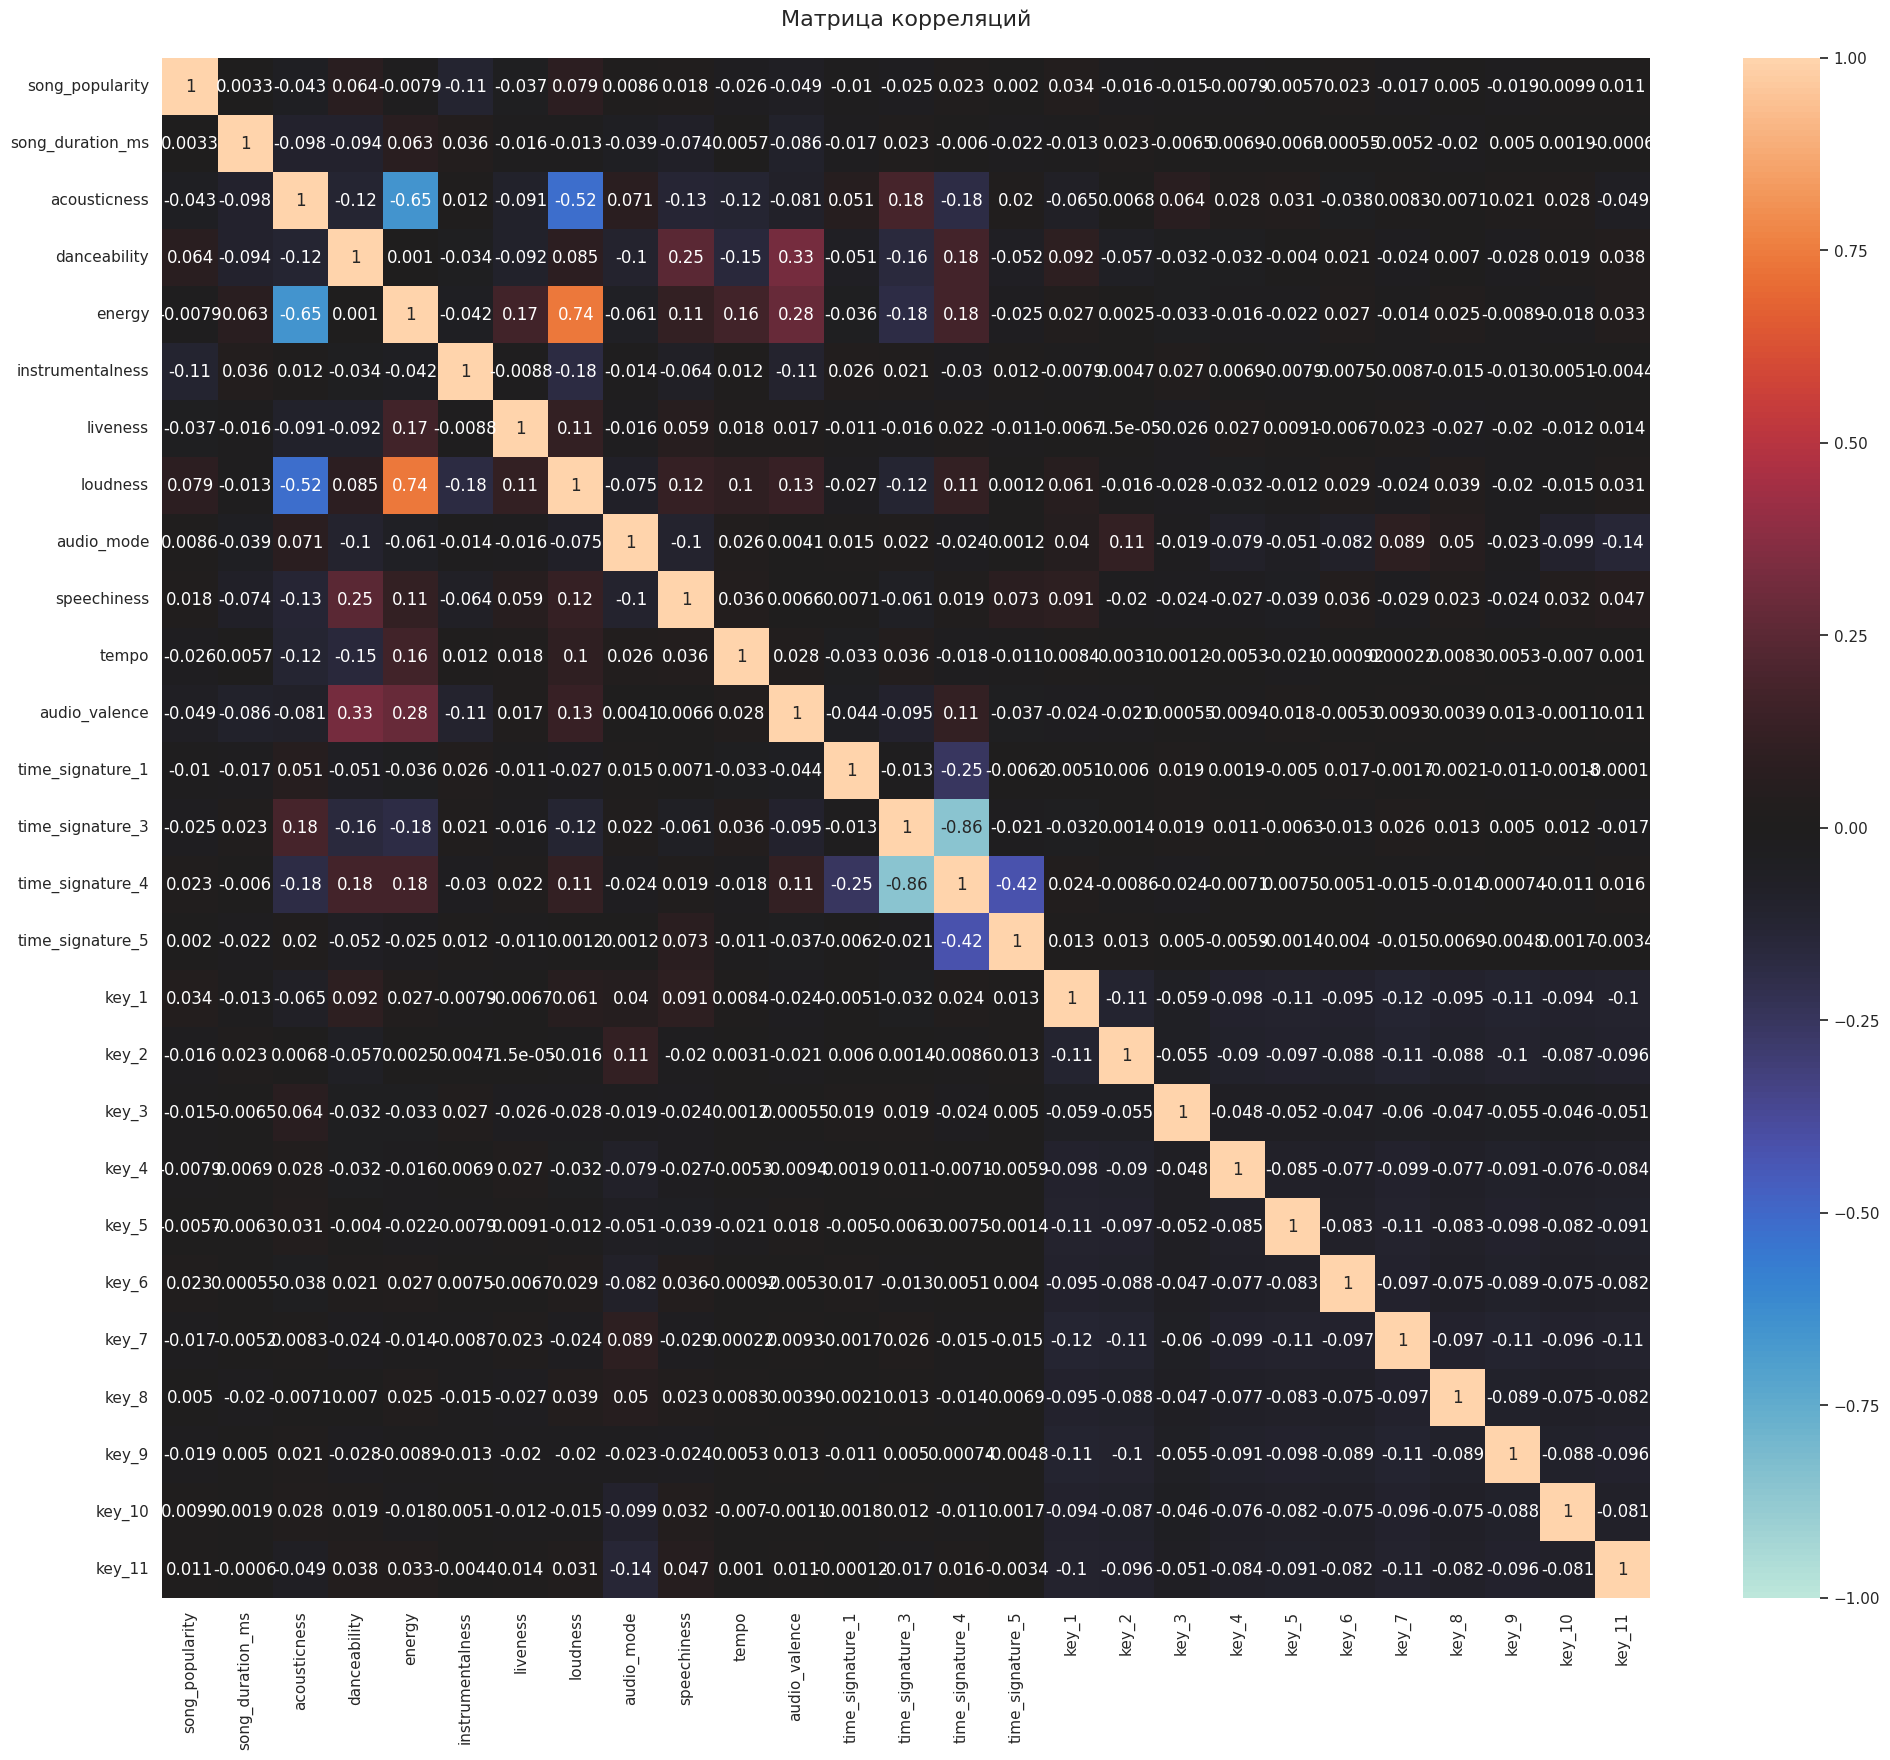

In [38]:
# Матрица корреляций
sns.set(rc={'figure.figsize':(24, 20)})
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0)
plt.title('Матрица корреляций\n', fontsize=16)
plt.show()

- Имеется очень сильная скоррелированность признаков time_signature_3 и time_signature_4. Целесообразно один из этих признаков из датасета исключить для повышения эффективности линейных моделей
- Отсутствует сколько-нибудь значимая корреляция целевого признака с любым из независимых признаков, что может осложнить построение эффективных моделей, особенно линейных

In [39]:
# создание датафрейма с оценкой необходимости включения признаков в модель
# (True - признак включается, False - признак не включается)

reccom_corr_mat = pd.Series(np.ones(len(df.columns) - 1), name='corr_mat', dtype=bool)
reccom_corr_mat[list(df.columns[1:]).index('time_signature_3')] = False     # исключение признака time_signature_3
reccom_corr_mat

0      True
1      True
2      True
3      True
4      True
5      True
6      True
7      True
8      True
9      True
10     True
11     True
12    False
13     True
14     True
15     True
16     True
17     True
18     True
19     True
20     True
21     True
22     True
23     True
24     True
25     True
Name: corr_mat, dtype: bool

### Отбор признаков на основе L1-регуляризации

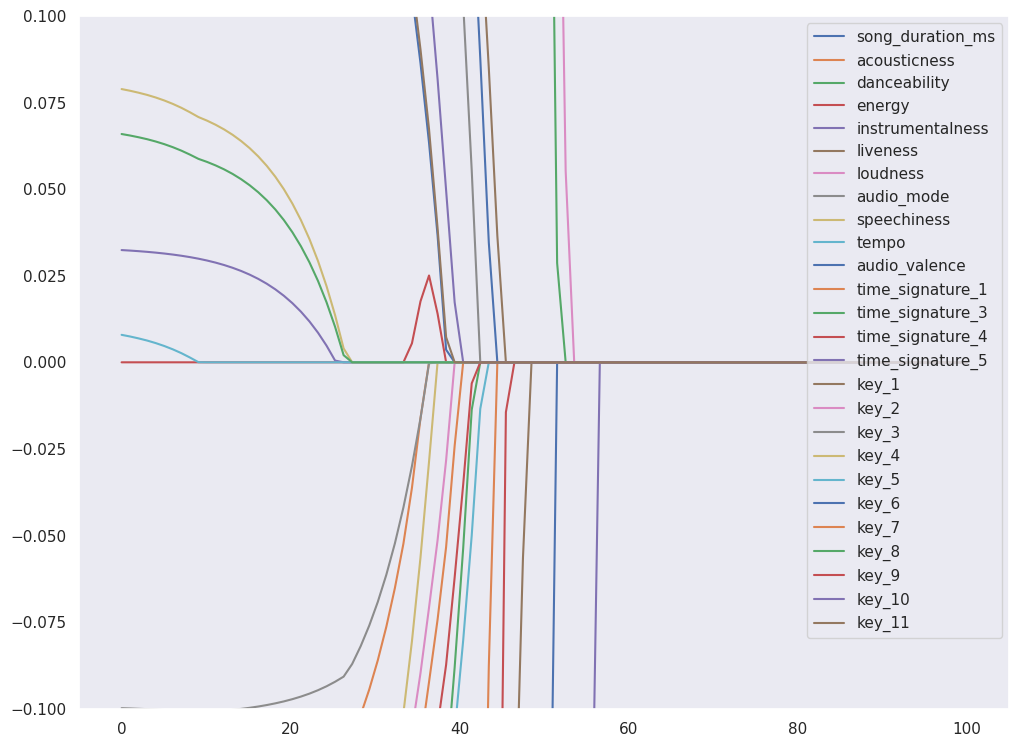

In [40]:
X_sc = StandardScaler().fit_transform(X)    # стандартизация данных для линейной модели
lg_l, pred_l = [], []

list_l = list(2**np.linspace(-10,10,100))

# построение "n" моделей Лассо с изменением коэффициентов регуляризации и сохранением модель и коэффициентов
for i in range(len(list_l)):
    m_l = Lasso(alpha=list_l[i]).fit(X_sc, y)
    lg_l.append(m_l)
    pred_l.append(m_l.coef_)

plt.figure(figsize=(12,9))
x_l = np.linspace(0,len(pred_l),len(pred_l))
for i in np.vstack(pred_l).T:
    plt.plot(x_l,np.sign(i)*np.abs(i))
plt.ylim(-0.1,0.1)
plt.legend(X.columns, loc="upper right")
plt.grid()

Исходя из графика, наименее значимы признаки key9, key5, key10, key8, key4, key6, time_signature_4, time_signature_1, key3

In [41]:
reccom_l1r = pd.Series(np.ones(len(df.columns) - 1), name='l1r', dtype=bool)
exclude = ['key_9', 'key_5', 'key_10', 'key_8', 'key_4', 'key_6', 'time_signature_4', 'time_signature_1', 'key_3']
for el in exclude:
    reccom_l1r[list(df.columns[1:]).index(el)] = False
reccom_l1r

0      True
1      True
2      True
3      True
4      True
5      True
6      True
7      True
8      True
9      True
10     True
11    False
12     True
13    False
14     True
15     True
16     True
17    False
18    False
19    False
20    False
21     True
22    False
23    False
24    False
25     True
Name: l1r, dtype: bool

### DecisionTree feature importance

In [42]:
array = df.values
X = array[:,1:]
Y = array[:,0]
names = df.columns[1:]

model = DecisionTreeRegressor()
model.fit(X, Y)

dic = {}

for i in range(len(names)):
    dic[names[i]] = model.feature_importances_[i]

print('Важность признаков в модели DecisionTree (по убыванию):')

for k, v in sorted(dic.items(), key=lambda x: x[1], reverse=True):
    print(f'{k}:  {v:4f}')

Важность признаков в модели DecisionTree (по убыванию):
audio_valence:  0.098017
song_duration_ms:  0.097478
acousticness:  0.096899
loudness:  0.096846
speechiness:  0.094624
energy:  0.092908
liveness:  0.092583
tempo:  0.091785
danceability:  0.087770
instrumentalness:  0.074956
audio_mode:  0.010167
key_1:  0.008162
key_7:  0.006673
key_2:  0.006340
key_9:  0.006194
key_6:  0.005834
key_5:  0.005485
key_11:  0.004758
key_8:  0.004649
key_3:  0.003607
time_signature_4:  0.003387
key_10:  0.003169
time_signature_5:  0.002757
key_4:  0.002640
time_signature_3:  0.001984
time_signature_1:  0.000327


Таким образом, наименее важные признаки (значимость менее 0.8%) - time_signature (все 4 признака), key (все 11 признаков)

In [43]:
df.columns

Index(['song_popularity', 'song_duration_ms', 'acousticness', 'danceability',
       'energy', 'instrumentalness', 'liveness', 'loudness', 'audio_mode',
       'speechiness', 'tempo', 'audio_valence', 'time_signature_1',
       'time_signature_3', 'time_signature_4', 'time_signature_5', 'key_1',
       'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9',
       'key_10', 'key_11'],
      dtype='object')

In [44]:
reccom_dtfi = pd.Series([True, True, True, True, True, True, True, True, True, True,
                         True, False, False, False, False, False, False, False, False,
                         False, False, False, False, False, False, False], name='DTFI')

### Recursive Feature Elimination (RFE)

In [45]:
# Подбор оптимального количества признаков

estimator = LinearRegression()
pipe_rfe = make_pipeline(RFE(estimator, step=1),
                         KNeighborsRegressor())

parameters = {'rfe__n_features_to_select': range(3, 25)}

grid_rfe = GridSearchCV(pipe_rfe, param_grid=parameters, scoring='neg_mean_squared_error', cv=7, n_jobs=-1)
grid_rfe.fit(StandardScaler().fit_transform(X_train), y_train)

print(f'Best parameters:  {grid_rfe.best_params_}')

Best parameters:  {'rfe__n_features_to_select': 10}


In [46]:
# Отбор признаков

selector = RFE(estimator, n_features_to_select=grid_rfe.best_params_['rfe__n_features_to_select'], step=1)
selector = selector.fit(X, y)
selector.get_support()

array([False,  True,  True,  True,  True,  True, False, False,  True,
       False,  True, False, False, False,  True,  True, False, False,
       False, False,  True, False, False, False, False, False])

In [47]:
reccom_RFE = pd.Series(selector.get_support(), name='RFE')

### Sequential Feature Selection (SFS)

In [48]:
knn = KNeighborsRegressor()
sfs = SequentialFeatureSelector(knn, n_features_to_select=grid_rfe.best_params_['rfe__n_features_to_select'])
sfs.fit(X, y)
sfs.get_support()

array([False, False, False, False,  True, False,  True, False, False,
       False, False,  True,  True, False, False, False,  True,  True,
       False,  True,  True,  True, False,  True, False, False])

In [49]:
reccom_sfs = pd.Series(sfs.get_support(), name='SFS')

### SHAP feature selection

In [50]:
X100 = shap.utils.sample(X_train, 100)   # выборочные 100 записей для использования в качестве фонового распределения

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Permutation explainer: 10658it [04:20, 39.79it/s]


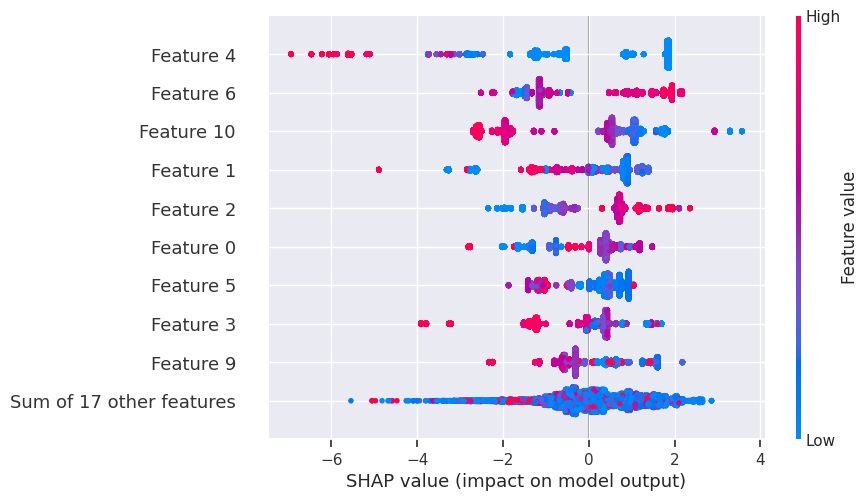

In [51]:
model_ebm = interpret.glassbox.ExplainableBoostingRegressor(interactions=0)
model_ebm.fit(X_train, y_train)

# интерпретация GAM-модели с помощью SHAP
explainer_ebm = shap.Explainer(model_ebm.predict, X100)
shap_values_ebm = explainer_ebm(X_train)

shap.plots.beeswarm(shap_values_ebm)

In [52]:
df.columns[1:]

Index(['song_duration_ms', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'audio_mode', 'speechiness',
       'tempo', 'audio_valence', 'time_signature_1', 'time_signature_3',
       'time_signature_4', 'time_signature_5', 'key_1', 'key_2', 'key_3',
       'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10',
       'key_11'],
      dtype='object')

=> наименьшую важность по SHAP имеют все dummy-разновидности признаков time_signature и key, а также признаки audio_mode и speechiness

In [53]:
reccom_shap = pd.Series([True, True, True, True, True, True, True, False, False, True,
                         True, False, False, False, False, False, False, False, False,
                         False, False, False, False, False, False, False], name='SHAP')

### Сводная оценка методов Feature selection

In [54]:
df_features = pd.DataFrame(df.columns[1:], columns=['Feature'])
df_corr_mat = pd.DataFrame(np.array(reccom_corr_mat), columns=['Corr.mat.'])
df_l1r = pd.DataFrame(np.array(reccom_l1r), columns=['L1-reg.'])
df_dtfi = pd.DataFrame(reccom_dtfi, columns=['DTFI'])
df_rfe = pd.DataFrame(reccom_RFE, columns=['RFE'])
df_sfs = pd.DataFrame(reccom_sfs, columns=['SFS'])
df_shap = pd.DataFrame(reccom_shap, columns=['SHAP'])

df_comparison = pd.concat([df_features, df_corr_mat, df_l1r, df_dtfi, df_rfe, df_sfs, df_shap], axis=1)

def get_overall_recommendation(row):
    '''
    Подсчет общего количества методов, по которым дана рекомендация учета
    конкретного признака при построении моделей
    '''
    count = 0
    for rec in row[1:]:
        if rec is True:
            count += 1
    return count

df_comparison['Overall'] = df_comparison.apply(get_overall_recommendation, axis=1)

df_comparison = df_comparison.sort_values(by='Overall', ascending=False)

df_comparison.style.bar(cmap='Blues', align='mid').hide_index()

Feature,Corr.mat.,L1-reg.,DTFI,RFE,SFS,SHAP,Overall
instrumentalness,True,True,True,True,True,True,6
audio_valence,True,True,True,True,False,True,5
danceability,True,True,True,True,False,True,5
energy,True,True,True,True,False,True,5
liveness,True,True,True,True,False,True,5
loudness,True,True,True,False,True,True,5
acousticness,True,True,True,True,False,True,5
song_duration_ms,True,True,True,False,False,True,4
tempo,True,True,True,False,False,True,4
speechiness,True,True,True,True,False,False,4


Признаки в таблице выше отсортированы по общему количеству рекомендаций по учету признаков в модели, полученных выше

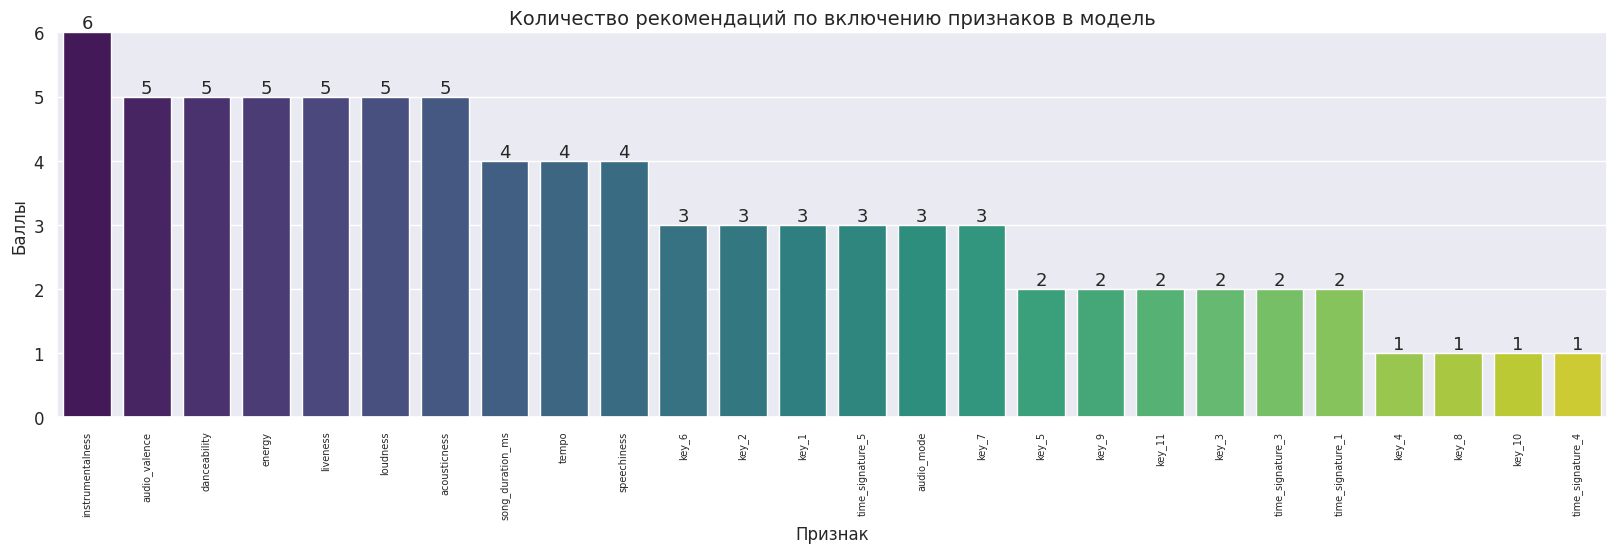

In [79]:
vdata = df_comparison[['Feature', 'Overall']].sort_values(by='Overall', ascending=False)

plt.rcParams['figure.figsize'] = (20,5)
fig, ax = plt.subplots()
sns.barplot(
    y='Overall',
    x='Feature',
    data=vdata,
    palette='viridis')
ax.set_ylim(0, 6)
plt.title('Количество рекомендаций по включению признаков в модель', fontsize=14)
plt.xlabel('Признак', fontsize=12)
plt.ylabel('Баллы', fontsize=12)
plt.xticks(rotation = 90)
plt.rc('ytick', labelsize=10)

rects = ax.patches
labels = [round(f, 4) for f in vdata['Overall']]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom", fontsize=13
    )


  => в итоговый состав фичей для моделей включаем фичи с Overall от 4 баллов и выше

In [55]:
features = df_comparison['Feature'][df_comparison['Overall'] >= 4]
feat_idx = list(features.index)

print(f'Итоговое количество признаков для построения моделей:  {len(features)}\n')
print(f'Признаки для построения моделей:\n{features}')

Итоговое количество признаков для построения моделей:  10

Признаки для построения моделей:
4     instrumentalness
10       audio_valence
2         danceability
3               energy
5             liveness
6             loudness
1         acousticness
0     song_duration_ms
9                tempo
8          speechiness
Name: Feature, dtype: object


In [56]:
X_train = X_train[:, feat_idx]
X_test = X_test[:, feat_idx]

In [57]:
# Размерность итогового массива обучающих данных X
X_train.shape

(10657, 10)

In [58]:
# Размерность итогового массива тестовых данных X
X_test.shape

(2665, 10)

## Обучение моделей

In [59]:
models = [LinearRegression(), Lasso(), SVR(), KNeighborsRegressor(),
          RandomForestRegressor(), XGBRegressor(), LGBMRegressor()]

df_metrics = pd.DataFrame(columns=['Model', 'MAE (test)', 'MSE (test)', 'RMSE (test)', 'R2 (test)',
                                   'MAE (train_cv)', 'MSE (train_cv)', 'R2 (train_cv)'])

for model in models:
    model_name = str(model)[:-2]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae_test = MAE(y_test, y_pred)
    mse_test = MSE(y_test, y_pred)
    rmse_test = np.sqrt(mse_test)
    r2_test = R2(y_test, y_pred)
    y_pred_train = model.predict(X_train)
    r2_train = R2(y_train, y_pred_train)
    mae_cv = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    mse_cv = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    r2_cv = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    df_metrics = pd.concat([df_metrics, pd.DataFrame([[model_name, round(mae_test, 2), round(mse_test, 2), round(rmse_test, 2), round(r2_test, 4),
                                                            abs(round(mae_cv.mean(), 2)), abs(round(mse_cv.mean(), 2)), abs(round(r2_cv.mean(), 4))]],
                                                            columns=['Model', 'MAE (test)', 'MSE (test)', 'RMSE (test)', 'R2 (test)', 'MAE (train_cv)',
                                                                     'MSE (train_cv)', 'R2 (train_cv)'])])

    print(f'Модель: {model_name}')
    print(f'Метрика MAE (на тестовой выборке):  {round(mae_test, 2)}')
    print(f'Метрика MSE (на тестовой выборке):  {round(mse_test, 2)}')
    print(f'Метрика RMSE (на тестовой выборке): {round(rmse_test, 2)}')
    print(f'Метрика R2  (на тестовой выборке):  {round(r2_test, 4)}')
    print(f'Метрика R2 (на обучающей выборке):  {round(r2_train, 4)}')
    print(f'Метрика MAE при кросс-валидации (5 фолдов):  {abs(round(mae_cv.mean(), 2))}')
    print(f'Метрика MSE при кросс-валидации (5 фолдов):  {abs(round(mse_cv.mean(), 2))}')
    print(f'Метрика R2  при кросс-валидации (5 фолдов):  {abs(round(r2_cv.mean(), 4))}\n')

Модель: LinearRegression
Метрика MAE (на тестовой выборке):  16.17
Метрика MSE (на тестовой выборке):  407.88
Метрика RMSE (на тестовой выборке): 20.2
Метрика R2  (на тестовой выборке):  0.0285
Метрика R2 (на обучающей выборке):  0.0341
Метрика MAE при кросс-валидации (5 фолдов):  16.1
Метрика MSE при кросс-валидации (5 фолдов):  409.69
Метрика R2  при кросс-валидации (5 фолдов):  0.0312

Модель: Lasso
Метрика MAE (на тестовой выборке):  16.41
Метрика MSE (на тестовой выборке):  420.02
Метрика RMSE (на тестовой выборке): 20.49
Метрика R2  (на тестовой выборке):  -0.0004
Метрика R2 (на обучающей выборке):  0.0
Метрика MAE при кросс-валидации (5 фолдов):  16.4
Метрика MSE при кросс-валидации (5 фолдов):  423.11
Метрика R2  при кросс-валидации (5 фолдов):  0.0005

Модель: SVR
Метрика MAE (на тестовой выборке):  15.7
Метрика MSE (на тестовой выборке):  407.65
Метрика RMSE (на тестовой выборке): 20.19
Метрика R2  (на тестовой выборке):  0.029
Метрика R2 (на обучающей выборке):  0.0302
Метри

In [60]:
df_metrics = df_metrics.reset_index(drop=True)
df_metrics.loc[5, 'Model'] = 'XGBRegressor'
df_metrics.set_index('Model').sort_values(by='MSE (test)').style.bar(cmap='Reds', align='mid', subset=['MAE (test)'])

,MAE (test),MSE (test),RMSE (test),R2 (test),MAE (train_cv),MSE (train_cv),R2 (train_cv)
Model,,,,,,,
SVR,15.700000,407.650000,20.190000,0.029000,15.740000,414.380000,0.020200
LinearRegression,16.170000,407.880000,20.200000,0.028500,16.100000,409.690000,0.031200
LGBMRegressor,16.160000,413.070000,20.320000,0.016100,16.090000,410.830000,0.028400
Lasso,16.410000,420.020000,20.490000,-0.000400,16.400000,423.110000,0.000500
RandomForestRegressor,16.330000,421.460000,20.530000,-0.003900,16.140000,416.070000,0.016200
XGBRegressor,16.900000,453.180000,21.290000,-0.079400,16.830000,449.140000,0.062100
KNeighborsRegressor,17.620000,494.620000,22.240000,-0.178100,17.330000,479.130000,0.133000


In [89]:
print(f'Стандартное отклонение целевого признака (тестовая выборка):  {round(y_test.std(), 2)}')
print(f'Дисперсия целевого признака (тестовая выборка):  {round(np.var(y_test), 2)}')

Стандартное отклонение целевого признака (тестовая выборка):  20.49
Дисперсия целевого признака (тестовая выборка):  419.84


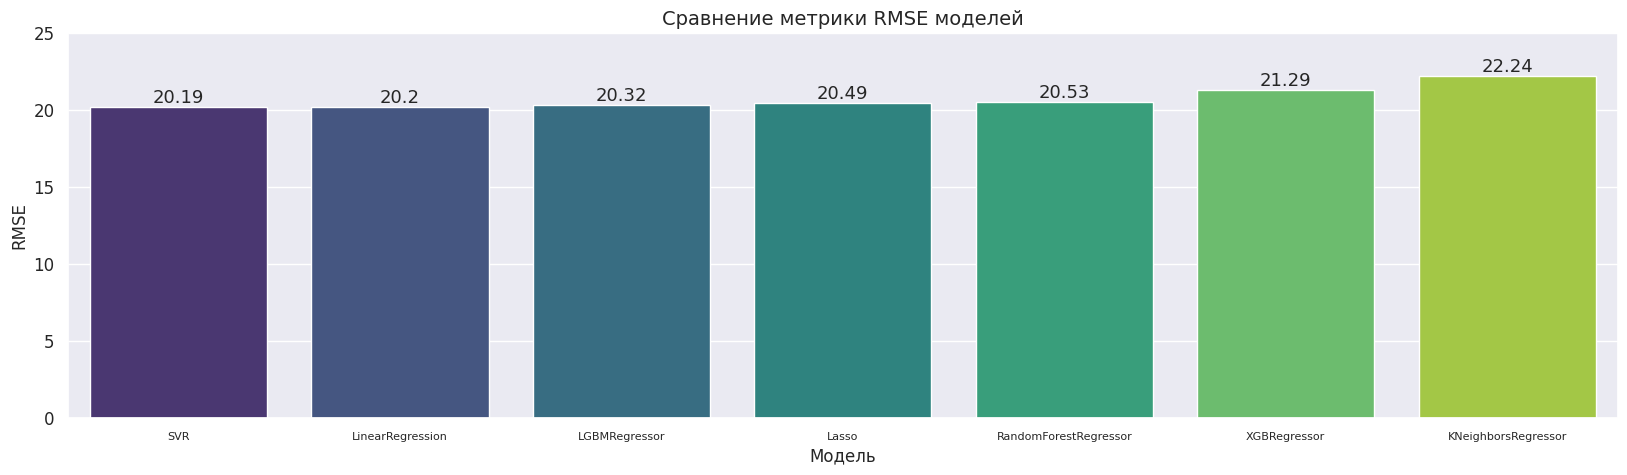

In [100]:
vdata = df_metrics.reset_index()[['Model', 'RMSE (test)']].sort_values(by='RMSE (test)')

plt.rcParams['figure.figsize'] = (20,5)
fig, ax = plt.subplots()
sns.barplot(
    y='RMSE (test)',
    x='Model',
    data=vdata,
    palette='viridis')
ax.set_ylim(0,25)
plt.title('Сравнение метрики RMSE моделей', fontsize=14)
plt.xlabel('Модель', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=12)

rects = ax.patches
labels = [round(f, 4) for f in vdata['RMSE (test)']]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom", fontsize=13
    )

**Промежуточные выводы:**
- классические модели ML имеют неудовлетворительную точность
- по результатам исследования получение моделей прогнозирования с качеством, достаточным для полноценного внедрения в целях повышения эффективности бизнес-процессов стримингового сервиса, не достигнуто

## Нейронная сеть

In [63]:
model = Sequential()
model.add(Dense(20, activation='relu', input_shape=[10,]))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(400, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mae')

In [64]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                220       
                                                                 
 dense_1 (Dense)             (None, 50)                1050      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 100)               5100      
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 400)               40400     
                                                                 
 dropout_2 (Dropout)         (None, 400)               0

In [65]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
334/334 [==============================] - 5s 7ms/step - loss: 20.4250 - val_loss: 16.4255
Epoch 2/100
334/334 [==============================] - 2s 5ms/step - loss: 17.3133 - val_loss: 17.4488
Epoch 3/100
334/334 [==============================] - 2s 5ms/step - loss: 16.9062 - val_loss: 15.8931
Epoch 4/100
334/334 [==============================] - 2s 5ms/step - loss: 16.5763 - val_loss: 16.2381
Epoch 5/100
334/334 [==============================] - 2s 6ms/step - loss: 16.4540 - val_loss: 16.2272
Epoch 6/100
334/334 [==============================] - 3s 8ms/step - loss: 16.4281 - val_loss: 16.0472
Epoch 7/100
334/334 [==============================] - 2s 5ms/step - loss: 16.3132 - val_loss: 16.4391
Epoch 8/100
334/334 [==============================] - 2s 5ms/step - loss: 16.2963 - val_loss: 16.1453
Epoch 9/100
334/334 [==============================] - 1s 4ms/step - loss: 16.2479 - val_loss: 15.9402
Epoch 10/100
334/334 [==============================] - 2s 5ms/step - los

<Axes: >

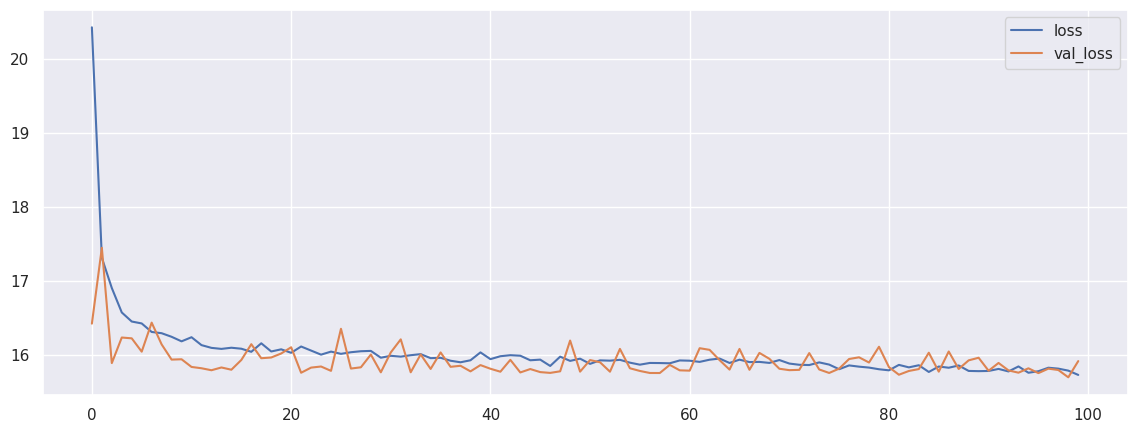

In [66]:
losses= pd.DataFrame(model.history.history)
plt.rcParams['figure.figsize'] = [14, 5]
losses.plot()

In [67]:
model.evaluate(X_test, y_test, verbose=2)

84/84 - 0s - loss: 15.9200 - 152ms/epoch - 2ms/step


15.920012474060059

**Выводы:**
- созданная искуственная нейронная сеть имеет метрику качества MAE на уровне лучшей модели классического ML (SVR)
- для повышения качества моделей требуется усложнение архитектуры / применение специальных архитектур нейронных сетей

**Рекомендации организации-держателю базы данных (стриминговый сервис):**
-  рекомендуется проанализировать необходимость изменения перечня параметров, заносимых в БД, в т.ч. внедрения новых полезных признаков для улучшения метрик моделей машинного обучения:
   - жанр песни
   - язык исполнения песни
   - пол вокалиста/вокалистки
   - мажорность/минорность
   - количество полных и неполных (прерванных) воспроизведений трека
   - иные значимые свойства